# Image Segmentation with Mask R-CNN

## Downloading the repository

In [ ]:
!git clone https://github.com/alsombra/Mask_RCNN-TF2

In [ ]:
%cd Mask_RCNN-TF2

In [ ]:
pwd

In [ ]:
!pip install -r requirements.txt

In [ ]:
!python setup.py install
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib

In [ ]:
%cd ..

In [ ]:
pwd

## Importing the libraries

In [ ]:
import os
import sys
import cv2
import numpy as np
import skimage.io
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [71]:
import keras
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)
print('numpy:', np.__version__)

tensorflow: 2.12.0
keras: 2.12.0
numpy: 1.23.5


In [ ]:
ROOT_DIR = os.path.abspath('./Mask_RCNN-TF2')
ROOT_DIR

In [ ]:
sys.path

In [ ]:
sys.path.append(ROOT_DIR)

In [ ]:
sys.path

In [ ]:
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib

In [ ]:
# https://cocodataset.org/#home
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))

In [ ]:
sys.path

In [ ]:
import coco

In [ ]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')

In [ ]:
MODEL_DIR, IMAGE_DIR

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Loading the pre-trained neural network

In [ ]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')

In [ ]:
utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
class InferenceConfig(coco.CocoConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

In [ ]:
config = InferenceConfig()

In [ ]:
config.display()

In [ ]:
MODEL_DIR

In [ ]:
network = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
network.load_weights(COCO_MODEL_PATH, by_name=True)

## Detecting objects

In [ ]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
len(class_names)

81

In [ ]:
class_names[1], class_names.index('person')

('person', 1)

In [ ]:
image = skimage.io.imread('/content/dog.jpg') # RGB

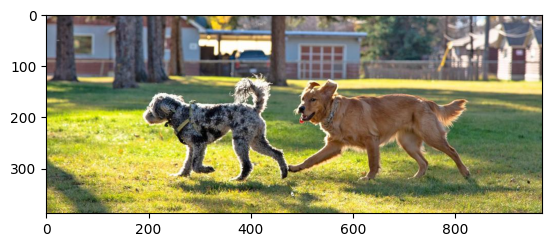

In [ ]:
plt.imshow(image);

In [ ]:
class_names[17], class_names[1], class_names[14]

('dog', 'person', 'bench')

In [ ]:
results = network.detect([image], verbose=0)
results

In [ ]:
r = results[0]

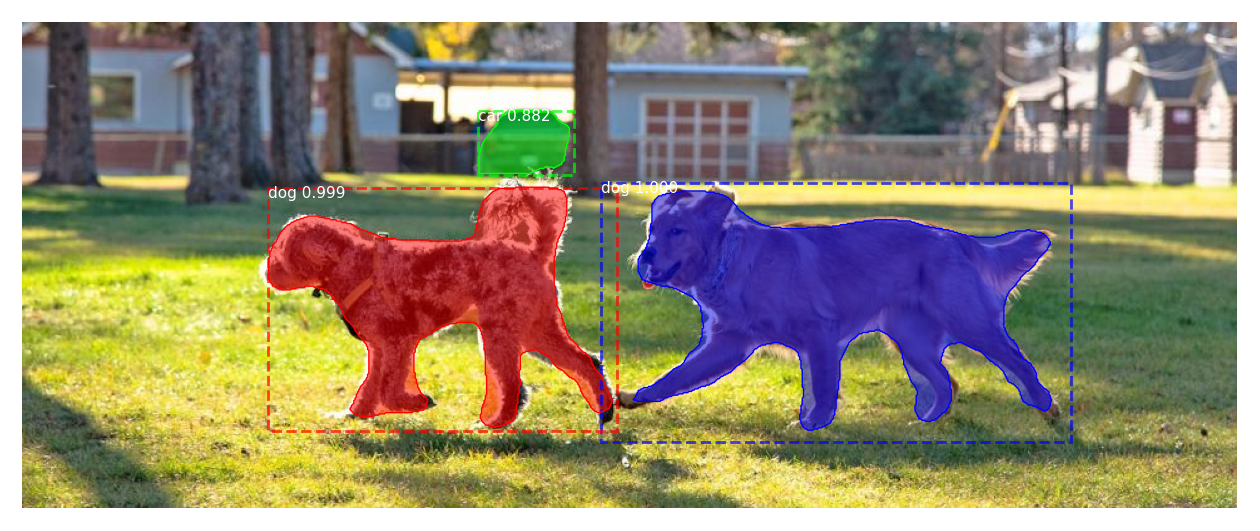

In [ ]:
visualize.display_instances(image, r['rois'], r['masks'],
                            r['class_ids'], class_names, r['scores'])

## Removing the background

In [ ]:
np.unique(r['masks'], return_counts=True)

(array([False,  True]), array([1066123,   62957]))

In [ ]:
r['masks']

In [ ]:
def segment(image, r, index):
  mask = r['masks'][:,:,index]
  #print(mask)
  #print(mask.shape)

  mask = np.stack((mask,) * 3, axis = -1)
  #print(mask)
  #print(mask.shape)

  mask = mask.astype('uint8')
  #print(mask)
  bg = 255 - mask * 255
  #print(mask, mask.min(), mask.max())

  mask_show = np.invert(bg)
  #print(mask_show)
  mask_img = image * mask
  #print(mask_img)

  result = mask_img + bg
  return result, mask_show

In [ ]:
segmentation, mask_obj = segment(image, r, 0)

In [ ]:
def show_segment(image, r, index, show_mask = False):
  segmentation, mask_obj = segment(image, r, index)
  plt.subplots(1, figsize=(16,16))
  plt.axis('off')
  if show_mask == True:
    plt.imshow(np.concatenate([mask_obj, segmentation], axis = 1))
  else:
    plt.imshow(np.concatenate([image, segmentation], axis = 1))

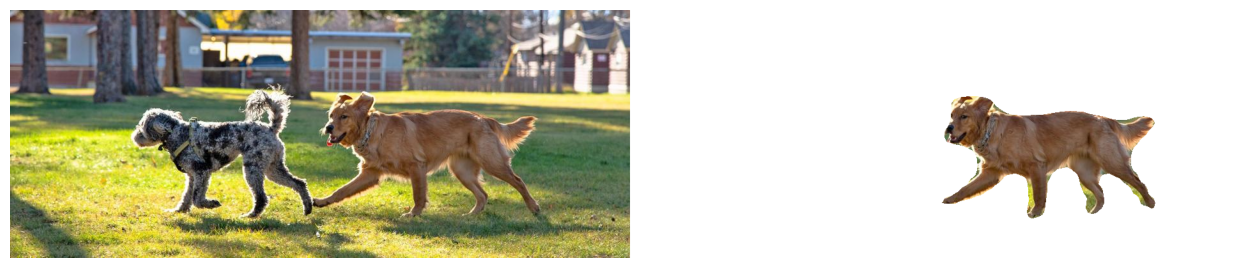

In [ ]:
show_segment(image, r, 0, False)

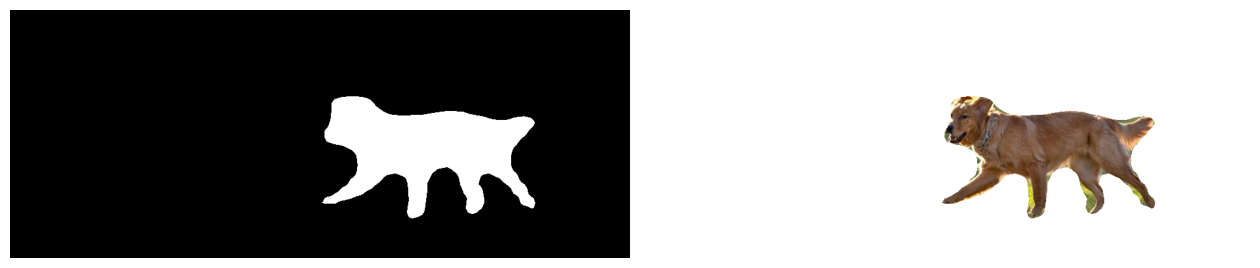

In [ ]:
show_segment(image, r, 0, True)

In [ ]:
r['rois'], len(r['rois'])

(array([[128, 462, 335, 837],
        [132, 196, 326, 475],
        [ 71, 364, 122, 440]], dtype=int32),
 3)

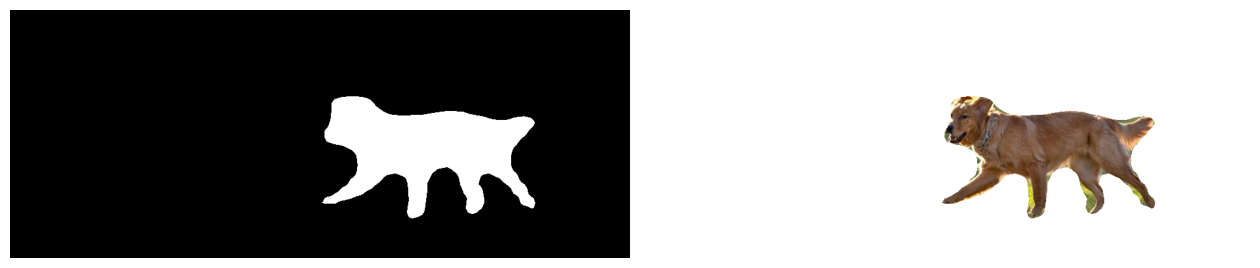

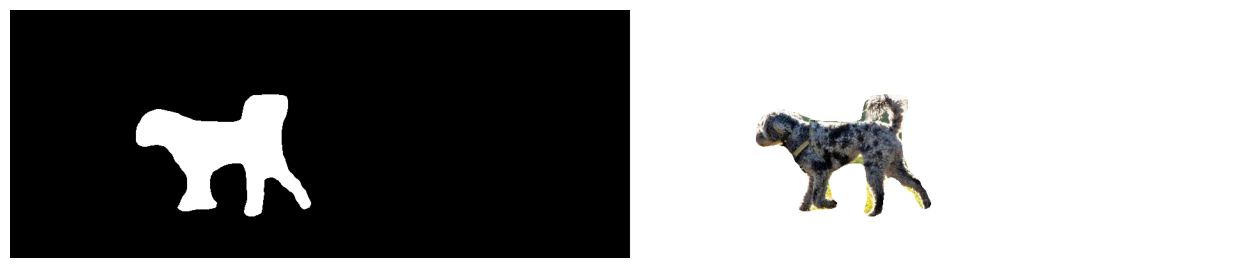

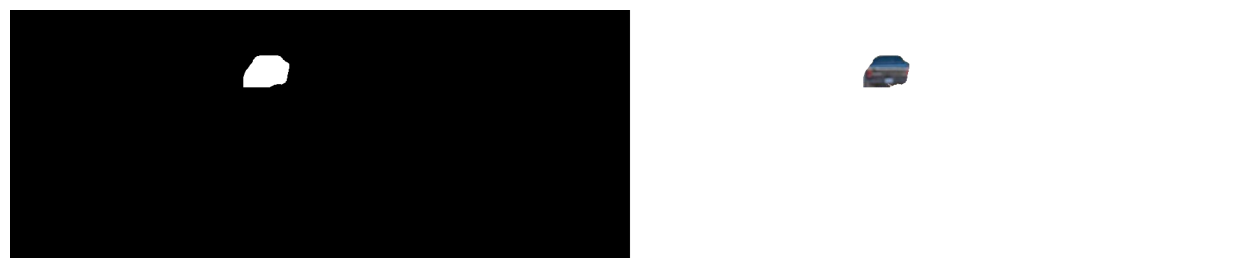

In [ ]:
for index in range(len(r['rois'])):
  show_segment(image, r, index, True)

## Segmentation in videos

In [ ]:
capture = cv2.VideoCapture('/content/vid.mp4')
connected, frame = capture.read()
connected

True

In [ ]:
frame.shape

(1080, 1920, 3)

In [ ]:
save_video = cv2.VideoWriter('/content/vid_result.avi',
                             cv2.VideoWriter_fourcc(*'XVID'), 24, (frame.shape[1], frame.shape[0]))

In [66]:
def apply_mask(image, mask):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image[:, :, 0] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 2]
    )
    return image

def display_instances(image, boxes, masks, ids, names, scores):
    # max_area will save the largest object for all the detection results
    max_area = 0

    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue

        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)

        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        if label == 'person':
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue

        # apply mask for the image
        image = apply_mask(image, mask)

    return image


In [67]:
#video segmentation is set to caputure a person (igonores other objects)

input_video = '/content/video1.mp4'
capture = cv2.VideoCapture(input_video)

fps = 25.0
width = int(capture.get(3))
height = int(capture.get(4))
fcc = cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
out = cv2.VideoWriter('/content/video_result.avi', fcc, fps, (width, height))

while True:
    ret, frame = capture.read()

    if frame is not None:
      results = network.detect([frame], verbose=0)
      r = results[0]

      #capturing object is set to 'person'
      frame = display_instances(
          frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
      )

      out.write(frame)
    else:
      break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows()